In [1]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from Train import MultivariateSigmoidNormalDiag
from Model import Actor, Critic
from VecEnv import EIEnv


In [2]:
env=EIEnv(gamma=0.9)

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
actor_net = Actor(env.observation_space.shape[0],env.action_space.shape[0]-30,30)
critic_net = Critic(env.observation_space.shape[0],30)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_net = actor_net.to(device)
critic_net = critic_net.to(device)
checkpoint = torch.load('./models/best')
actor_net.load_state_dict(checkpoint['actor_model_state_dict'],strict=False)
critic_net.load_state_dict(checkpoint['critic_model_state_dict'],strict=False)
actor_net.eval()
critic_net.eval()

Critic(
  (hiden): Sequential(
    (0): Linear(in_features=76, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
  )
  (gen_v): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (BES_v): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (AC_v): Sequential(
    (0): Linear(in_features=76, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=30, bias=True)
  )
)

In [4]:
import torch.distributions as dist
import numpy as np
gamma=0.9
np.random.seed(100)
steps=np.zeros([1438,76])
values = np.zeros(1438)
gen_costs = []
bes_costs = []
AC_costs = []
AC_actions = torch.zeros([1438,30])
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1438)):
    
        observation_in=env.observation_scalar(observation)
        
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        EV_mu, EV_sigma, AC_prob = actor_net(observation_in)
        gen_value, BES_value, AC_values = critic_net(observation_in)
        #policies_probs = MultivariateSigmoidNormalDiag(policies_mu,5*policies_sigma+1e-2)
        EV_probs = dist.normal.Normal(EV_mu,EV_sigma+1e-4)
        #压缩到0.2-0.8之间
        AC_prob = 0.2 + 0.6*AC_prob
        AC_probs = dist.bernoulli.Bernoulli(AC_prob)
        EV_actions = EV_probs.sample()
        AC_actions = AC_probs.sample()
        actions = torch.cat((EV_actions,AC_actions),dim=1)
        # gather env data, reset done envs and update their obs
        observation, gen_cost, bes_cost, AC_cost, _, _= env.step(actions.detach().cpu().numpy()[0])
        #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
        steps[step]=env.state
        gen_costs.append(gen_cost)
        bes_costs.append(bes_cost)
        AC_costs.append(AC_cost)

In [14]:
import torch.distributions as dist
import numpy as np
gamma=0.9
np.random.seed(100)
steps=np.zeros([1438,76])
gen_costs = []
bes_costs = []
AC_costs = []
AC_actions = torch.zeros([1438,30])
values = np.zeros(1438)
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1438)):
    
        observation_in=env.observation_scalar(observation)
        
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)

        # network forward pass
        EV_mu, EV_sigma, AC_prob = actor_net(observation_in)     
        #AC_prob = 0.2 + 0.6*AC_prob
        #AC_probs = dist.bernoulli.Bernoulli(AC_prob)
        #EV_probs = dist.normal.Normal(EV_mu,EV_sigma+1e-4)

        #EV_actions = EV_probs.sample()
        #AC_actions = AC_probs.sample()
        #actions = torch.cat((EV_actions,AC_actions),dim=1)
        actions = torch.cat((EV_mu,(AC_prob>0.5).to(torch.float)),dim=1)
        # gather env data, reset done envs and update their obs
        observation, gen_cost, bes_cost, AC_cost, _, _= env.step(actions.detach().cpu().numpy()[0])
        #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
        steps[step]=env.state
        gen_costs.append(gen_cost)
        bes_costs.append(bes_cost)
        AC_costs.append(AC_cost)

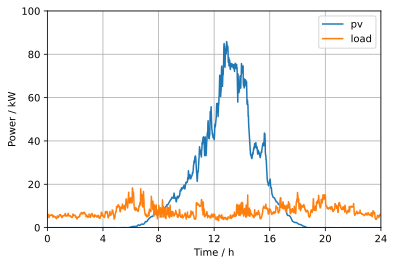

In [44]:
plt.plot(steps[:,0], steps[:,1], label='pv')
plt.plot(steps[:,0], steps[:,4], label='load')
#plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
plt.ylim(0,100)
plt.xlim(0,24)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

In [6]:
import os
os.getcwd()

'/home/zhaoming/RL/Liu_Hua/oneday_multi_reward'

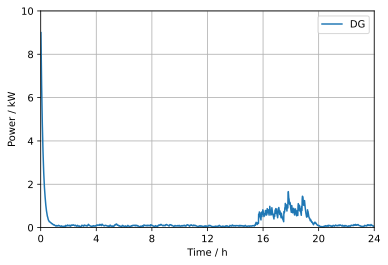

In [48]:
plt.plot(steps[:,0], steps[:,2], label='DG')
plt.xlim(0,24)
plt.ylim(0,10)
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

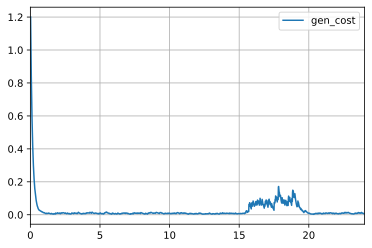

In [47]:
plt.plot(steps[:,0], gen_costs, label='gen_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

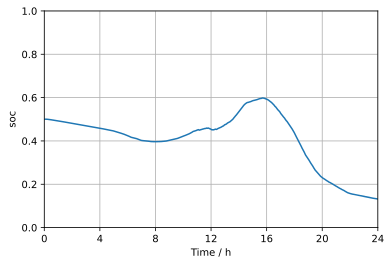

In [46]:
plt.plot(steps[:,0], steps[:,3])
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

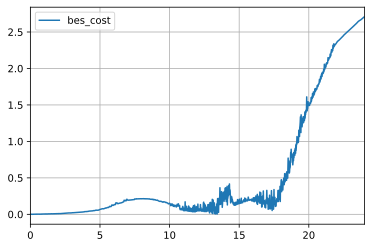

In [45]:
plt.plot(steps[:,0], bes_costs, label='bes_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

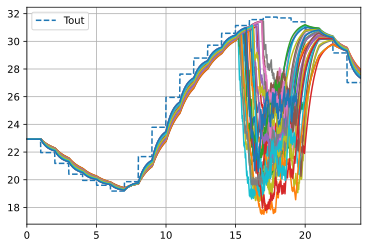

In [11]:
plt.plot(steps[:,0],steps[:,5], '--', label='Tout')
for i in range(30):
    plt.plot(steps[:,0],steps[:,-(i+1)])
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

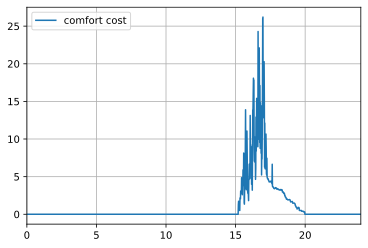

In [49]:
plt.plot(steps[:,0],np.sum(np.array(AC_costs),axis=1), label='comfort cost')
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

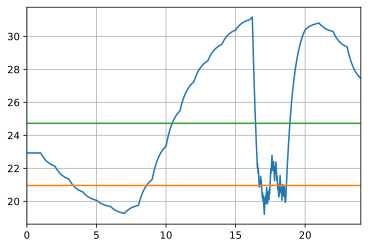

In [14]:
n=1
plt.plot(steps[:,0],steps[:,-(30-n)])
plt.plot(steps[:,0], env.Tlower[n]*np.ones(1438), label='Tlower')
plt.plot(steps[:,0], env.Tupper[n]*np.ones(1438), label='Tupper')
plt.xlim(0,24)
plt.grid()
plt.show()

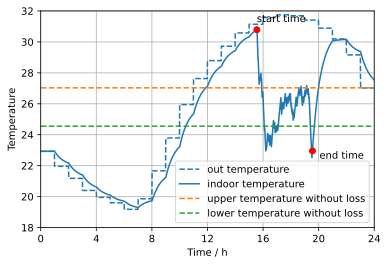

In [23]:
n=10
plt.plot(steps[:,0],steps[:,5], '--', label='out temperature')
plt.plot(steps[:,0],steps[:,-(30-n)], 'C0', label = 'indoor temperature')
plt.plot(steps[:,0], env.Tupper[n]*np.ones(1438), 'C1--' ,label='upper temperature without loss')
plt.plot(steps[:,0], env.Tlower[n]*np.ones(1438),'C2--', label='lower temperature without loss')
plt.plot(env.start_AC_time[n], steps[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
plt.text(env.start_AC_time[n], steps[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
plt.plot(env.end_AC_time[n], steps[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
plt.text(env.end_AC_time[n]+0.5, steps[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.xlim(0,24)
plt.ylim(18,32)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

In [13]:
AC_prob

tensor([[0.5088, 0.4213, 0.4929, 0.4310, 0.4612, 0.4738, 0.4232, 0.3834, 0.4665,
         0.3706, 0.5076, 0.4220, 0.3778, 0.4030, 0.4274, 0.4726, 0.4845, 0.4466,
         0.4706, 0.4166, 0.4867, 0.4511, 0.3990, 0.5048, 0.4969, 0.4695, 0.4204,
         0.3794, 0.4252, 0.4425]], device='cuda:0')

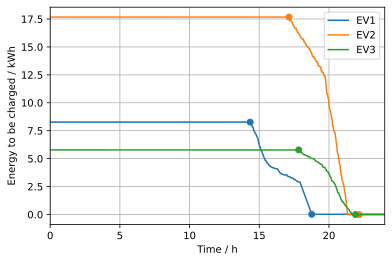

In [12]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(env.start_charge_time[0],steps[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(env.start_charge_time[10],steps[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps[-1,16],'C1o')
plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
plt.plot(env.start_charge_time[15],steps[0,21],'C2o')
plt.plot(env.end_charge_time[15],steps[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.ylabel('Energy to be charged / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/EV.svg',format='svg')
plt.show()

In [7]:
np.random.seed(100)
steps_compare=np.zeros([1438,76])
AC_action = np.zeros([30])
observation = env.reset()
for step in range(int(1438)):
    Tin = env.state[-30:] 
    for i in range(30):
        #若不在控制时间内，保持控制信号为0
        if env.AC_sign[i]==True:
            if Tin[i]>=env.Tupper[i]+3:
                AC_action[i] = 1
            elif Tin[i]<=env.Tlower[i]-3:
                AC_action[i] = 0
    actions = np.concatenate(([0],np.ones(20),AC_action), axis=0)
    # gather env data, reset done envs and update their obs
    observation, gen_cost, bes_cost, AC_cost, _, _= env.step(actions)
    #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
    steps_compare[step]=env.state

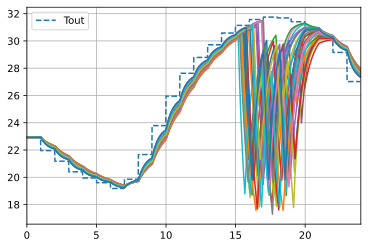

In [8]:
plt.plot(steps_compare[:,0],steps_compare[:,5], '--', label='Tout')
for i in range(30):
    plt.plot(steps_compare[:,0],steps_compare[:,-(i+1)])
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

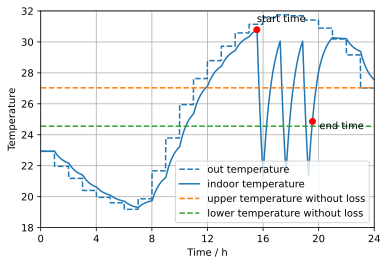

In [22]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], '--', label='out temperature')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C0', label = 'indoor temperature')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C1--' ,label='upper temperature without loss')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--', label='lower temperature without loss')
plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.xlim(0,24)
plt.ylim(18,32)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

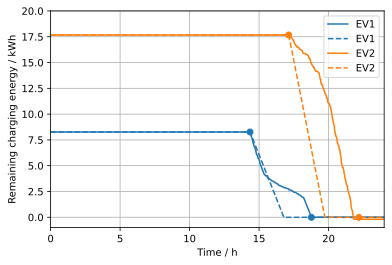

In [43]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(steps_compare[:,0],steps_compare[:,6], 'C0--', label='EV1')
plt.plot(env.start_charge_time[0],steps_compare[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps_compare[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(steps_compare[:,0],steps_compare[:,6+10], 'C1--', label='EV2')
plt.plot(env.start_charge_time[10],steps_compare[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps_compare[-1,16],'C1o')
#plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
#plt.plot(steps_compare[:,0],steps_compare[:,6+15],'C2--', label='EV3')
#plt.plot(env.start_charge_time[15],steps_compare[0,21],'C2o')
#plt.plot(env.end_charge_time[15],steps_compare[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.ylim(-1,20)
plt.ylabel('Remaining charging energy / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/EV.svg',format='svg')
plt.show()

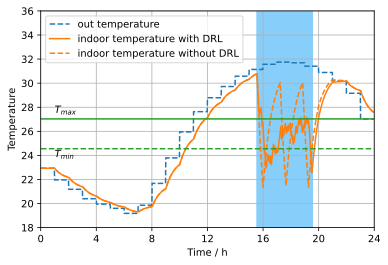

In [42]:
n=10
plt.plot(steps_compare[:,0],steps_compare[:,5], 'C0--', label='out temperature')
plt.plot(steps[:,0],steps[:,-(30-n)], 'C1', label = 'indoor temperature with DRL')
plt.plot(steps_compare[:,0],steps_compare[:,-(30-n)], 'C1--', label = 'indoor temperature without DRL')
plt.plot(steps_compare[:,0], env.Tupper[n]*np.ones(1438), 'C2')
plt.text(1, env.Tupper[n]+0.5, '$T_{max}$')
plt.plot(steps_compare[:,0], env.Tlower[n]*np.ones(1438),'C2--')
plt.text(1, env.Tlower[n]-0.7, '$T_{min}$')
#plt.plot(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)], 'ro')
#plt.text(env.start_AC_time[n], steps_compare[int(60*env.start_AC_time[n])-1,-(30-n)]+0.5, 'start time')
#plt.plot(env.end_AC_time[n], steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)],'ro')
#plt.text(env.end_AC_time[n]+0.5, steps_compare[int(60*env.end_AC_time[n])-1,-(30-n)]-0.5, 'end time')
plt.fill_between(np.linspace(env.start_AC_time[n],env.end_AC_time[n],100),18*np.ones(100), 36*np.ones(100),color='lightskyblue')
plt.xlim(0,24)
plt.ylim(18,36)
plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

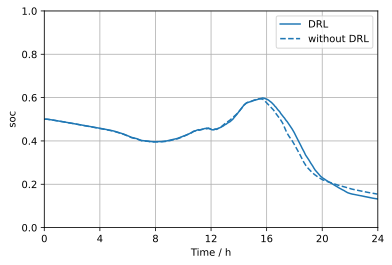

In [34]:
plt.plot(steps[:,0], steps[:,3], 'C0', label='DRL')
plt.plot(steps_compare[:,0], steps_compare[:,3], 'C0--', label='without DRL')
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('soc')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()